In [3]:
import getpass
import os
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Access the keys to not input them every time
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ['SSL_CERT_FILE'] = '/etc/ssl/certs/ca-certificates.crt' # needed for anthropic api
os.environ['REQUESTS_CA_BUNDLE'] = "/etc/ssl/certs/ca-certificates.crt" # needed for langsmith api

from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic

from typing import Annotated, Literal

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel

from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

## Customizing State

Adding the choice to rely on a human. For that, we will create a "human" node which will be only executed if LLM invokes a "human" tool. We will flag it as ``ask_human``.

Let's define a schema to request assistance and the chatbot node.

In [59]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool # whether to ask the human for input

class RequestAssistance(BaseModel):
    """Request assistance from an expert. Do this if you're stuck on unable to proceed.
    For this, pass the urser's request to the expert.
    """

    request: str

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022")
# Bind it to tools and RequestAssistance (also could be a json schema)
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

def chatbot(state: State) -> State:
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (response.tool_calls and response.tool_calls[0]["name"] == RequestAssistance.__name__):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [60]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

Create the "human" node, acting as a placeholder that will trigger an interrupt. If human does not manually update state during the interruption, it will insert a tool message that input was requested but didn't respond (so unsetting ``ask_human`` flag to not revisit him again until further request).

In [61]:
def create_response(response: str, ai_message: AIMessage):
    """
    Create a response message with the given content and
    the tool_call_id of the given AIMessage.
    """
    return ToolMessage(content= response,
                       tool_call_id = ai_message.tool_calls[0]["id"])

def human_node(state: State) -> State:
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage): # when user didn't update the tool
        new_messages.append(
            create_response("No response from user.",
                            state["messages"][-1])
        )

    return {
        "messages": new_messages,
        "ask_human": False
        }

graph_builder.add_node("human", human_node)

Define ``select_next_node`` to route to ``human`` node if the flag is set. Otherwise, let the tools condition to choose next.

In [62]:
def select_next_node(state: State):
    """Select the next node based on the state."""

    if state["ask_human"]:
        return "human"
    return tools_condition(state)


# This part 
graph_builder.add_conditional_edges("chatbot", select_next_node,
                                    {"human": "human", "tools": "tools", END: END}) 

In [63]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"] # interrupt before the human node
)

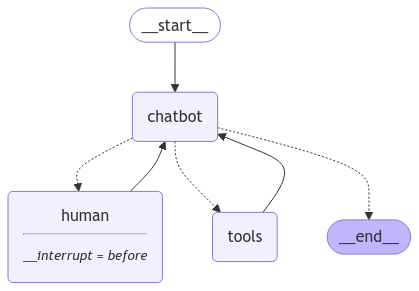

In [64]:
display(Image(graph.get_graph().draw_mermaid_png()))

The possible paths for the chatbot are:
1. `chatbot` -> `human`
2. `chatbot` -> `tools`
3. `chatbot` -> `end` (respond)

In [65]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]},
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "I'll help you request expert assistance for building an AI agent.", 'type': 'text'}, {'id': 'toolu_018oWotrwPEUA8DrX4ucJ2SL', 'input': {'request': 'I need expert guidance for building an AI agent. Please provide assistance with the development process.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]
Tool Calls:
  RequestAssistance (toolu_018oWotrwPEUA8DrX4ucJ2SL)
 Call ID: toolu_018oWotrwPEUA8DrX4ucJ2SL
  Args:
    request: I need expert guidance for building an AI agent. Please provide assistance with the development process.


Note that LLM has invoked ``RequestAssistance`` tool, so it has been interrupted. The next state should be the human:

In [66]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [67]:
snapshot.metadata

{'source': 'loop',
 'writes': {'chatbot': {'messages': [AIMessage(content=[{'text': "I'll help you request expert assistance for building an AI agent.", 'type': 'text'}, {'id': 'toolu_018oWotrwPEUA8DrX4ucJ2SL', 'input': {'request': 'I need expert guidance for building an AI agent. Please provide assistance with the development process.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UfahA5uvYskbgXCRkuBjF7', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 513, 'output_tokens': 84}}, id='run-1087e069-299e-4ff7-8a91-3bfc82cfc0de-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance for building an AI agent. Please provide assistance with the development process.'}, 'id': 'toolu_018oWotrwPEUA8DrX4ucJ2SL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 513, 'output_tokens': 84, 'total_tokens': 597, 'input_token_details': {

Create the tool_message with our response and call the update_state to manually modify it.

In [68]:
ai_message = snapshot.values["messages"][-1]
ai_message

AIMessage(content=[{'text': "I'll help you request expert assistance for building an AI agent.", 'type': 'text'}, {'id': 'toolu_018oWotrwPEUA8DrX4ucJ2SL', 'input': {'request': 'I need expert guidance for building an AI agent. Please provide assistance with the development process.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UfahA5uvYskbgXCRkuBjF7', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 513, 'output_tokens': 84}}, id='run-1087e069-299e-4ff7-8a91-3bfc82cfc0de-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance for building an AI agent. Please provide assistance with the development process.'}, 'id': 'toolu_018oWotrwPEUA8DrX4ucJ2SL', 'type': 'tool_call'}], usage_metadata={'input_tokens': 513, 'output_tokens': 84, 'total_tokens': 597, 'input_token_details': {}})

In [69]:
ai_message = snapshot.values["messages"][-1]
human_response = ("Hey friend! My recommendation is to use LangGraph framework to build your AI agent."
                "It's a powerful tool that can help you build complex conversational agents."
)

tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa9b3c-69c8-63d4-8002-552317176df6'}}

In [70]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='450ed4dd-ff60-4011-9749-08ed4b8e9fee'),
 AIMessage(content=[{'text': "I'll help you request expert assistance for building an AI agent.", 'type': 'text'}, {'id': 'toolu_018oWotrwPEUA8DrX4ucJ2SL', 'input': {'request': 'I need expert guidance for building an AI agent. Please provide assistance with the development process.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01UfahA5uvYskbgXCRkuBjF7', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 513, 'output_tokens': 84}}, id='run-1087e069-299e-4ff7-8a91-3bfc82cfc0de-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need expert guidance for building an AI agent. Please provide assistance with the development process.'}, 'id': 'toolu_01

Resume graph by invoking None

In [71]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

Hey friend! My recommendation is to use LangGraph framework to build your AI agent.It's a powerful tool that can help you build complex conversational agents.
================================= Tool Message =================================

Hey friend! My recommendation is to use LangGraph framework to build your AI agent.It's a powerful tool that can help you build complex conversational agents.
================================== Ai Message ==================================

Based on the expert's response, they recommend using the LangGraph framework for building your AI agent. This is a specialized tool designed for creating complex conversational agents. Would you like to know more specific details about how to proceed with LangGraph, or do you have any particular aspects of AI agent development you'd like to focus on?


## Time travel

In [4]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

In [5]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'll search for information about LangGraph to help you learn about it.", 'type': 'text'}, {'id': 'toolu_01MKR3qnorBe8Wh9mqii4Kat', 'input': {'query': 'What is LangGraph framework in AI development? How to use LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01MKR3qnorBe8Wh9mqii4Kat)
 Call ID: toolu_01MKR3qnorBe8Wh9mqii4Kat
  Args:
    query: What is LangGraph framework in AI development? How to use LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "Use LangGraph Platform to templatize your cognitive architecture so that tools, prompts, and models a

In [6]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': 'Let me search for specific information about building autonomous agents with LangGraph!', 'type': 'text'}, {'id': 'toolu_01XCKUsuUVgFdZ4TS2qiv2uJ', 'input': {'query': 'how to build autonomous agents with LangGraph examples tutorial'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01XCKUsuUVgFdZ4TS2qiv2uJ)
 Call ID: toolu_01XCKUsuUVgFdZ4TS2qiv2uJ
  Args:
    query: how to build autonomous agents with LangGraph examples tutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "Quick Start. Learn the basics of LangGraph through a comprehensive quick star

Let's rewind our graph using ``get_state_history`` method. We can replay the full state history to see everythin that occurred.

In [19]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num messages:" , len(state.values["messages"]), "Next: ", state.next)
    print("--" * 80)
    if len(state.values["messages"]) == 4: # e.g.
        to_replay = state


Num messages: 12 Next:  ()
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Num messages: 11 Next:  ('chatbot',)
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Num messages: 10 Next:  ('tools',)
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Num messages: 9 Next:  ('chatbot',)
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Num messages: 8 Next:  ('tools',)
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Num messages: 7 Next:  ('c

In [20]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9e97-1c6a-6395-8003-cf5cfd4ca161'}}


We have selected to replay it before chatbot, in tools.

In [21]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': 'Let me do another search to get more specific details about its implementation and features.', 'type': 'text'}, {'id': 'toolu_01KmQVTPYtEzFf4ciu8mSmBi', 'input': {'query': 'LangGraph tutorial implementation examples features Python'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01KmQVTPYtEzFf4ciu8mSmBi)
 Call ID: toolu_01KmQVTPYtEzFf4ciu8mSmBi
  Args:
    query: LangGraph tutorial implementation examples features Python
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/tutorials/", "content": "These notebooks introduce LangGraph through building various language agents and applications. Learn the basics of LangGraph through a comprehensive quick start in which you will build an agent from scratch. Quick Start: In this 

And voilá! We used time-travel checkpoint to replay the graph from the desired node.